# 3.5 Factor Analysis on Financial and Economic Time Series

Factor Analysis and Principal Component Analysis on Financial and Economic Time Series

In [1]:
# If you're running this on Colab, make sure to install the following packages using pip.
# On you're own computer, I recommend using conda or mamba.

# !pip install pandas-datareader
# !pip install yfinance

# !conda install pandas-datareader
# !conda install yfinance

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import yfinance as yf
import pandas_datareader as pdr
import sklearn.decomposition
import statsmodels.multivariate.pca

## Downloading macroeconomic and financial data from FRED

In [3]:
fred_series_long_names = {
    'BAMLH0A0HYM2': 'ICE BofA US High Yield Index Option-Adjusted Spread',
    'NASDAQCOM': 'NASDAQ Composite Index',
    'RIFSPPFAAD90NB': '90-Day AA Financial Commercial Paper Interest Rate',
    'TB3MS': '3-Month Treasury Bill Secondary Market Rate',
    'DGS10': 'Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity',
    'VIXCLS': 'CBOE Volatility Index: VIX',
}

In [4]:
fred_series_short_names = {
    'BAMLH0A0HYM2': 'High Yield Index OAS',
    'NASDAQCOM': 'NASDAQ',
    'RIFSPPFAAD90NB': '90-Day AA Fin CP',
    'TB3MS': '3-Month T-Bill',
    'DGS10': '10-Year Treasury',
    'VIXCLS': 'VIX',
}

In [5]:
start_date = pd.to_datetime('1980-01-01') 
end_date = pd.to_datetime('today') 

In [6]:
df = pdr.get_data_fred(fred_series_short_names.keys(), start=start_date, end=end_date)

First, an aside about reading and writing data to disk.

In [7]:
df.to_csv('fred_panel.csv')

In [8]:
dff = pd.read_csv('fred_panel.csv')

In [9]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11877 entries, 0 to 11876
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            11877 non-null  object 
 1   BAMLH0A0HYM2    7202 non-null   float64
 2   NASDAQCOM       11241 non-null  float64
 3   RIFSPPFAAD90NB  6467 non-null   float64
 4   TB3MS           535 non-null    float64
 5   DGS10           11148 non-null  float64
 6   VIXCLS          8727 non-null   float64
dtypes: float64(6), object(1)
memory usage: 649.7+ KB


In [10]:
dff = pd.read_csv('fred_panel.csv', parse_dates=['DATE'])

In [11]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11877 entries, 0 to 11876
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            11877 non-null  datetime64[ns]
 1   BAMLH0A0HYM2    7202 non-null   float64       
 2   NASDAQCOM       11241 non-null  float64       
 3   RIFSPPFAAD90NB  6467 non-null   float64       
 4   TB3MS           535 non-null    float64       
 5   DGS10           11148 non-null  float64       
 6   VIXCLS          8727 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 649.7 KB


In [12]:
dff = dff.set_index('DATE')

In [13]:
df.to_parquet('fred_panel.parquet')

In [14]:
df = pd.read_parquet('fred_panel.parquet')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11877 entries, 1980-01-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BAMLH0A0HYM2    7202 non-null   float64
 1   NASDAQCOM       11241 non-null  float64
 2   RIFSPPFAAD90NB  6467 non-null   float64
 3   TB3MS           535 non-null    float64
 4   DGS10           11148 non-null  float64
 5   VIXCLS          8727 non-null   float64
dtypes: float64(6)
memory usage: 649.5 KB


In [16]:
df

,BAMLH0A0HYM2,NASDAQCOM,RIFSPPFAAD90NB,TB3MS,DGS10,VIXCLS
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,12.0,NaN,NaN
1980-01-02,NaN,148.17,NaN,NaN,10.50,NaN
1980-01-03,NaN,145.97,NaN,NaN,10.60,NaN
1980-01-04,NaN,148.02,NaN,NaN,10.66,NaN
1980-01-07,NaN,148.62,NaN,NaN,10.63,NaN
...,...,...,...,...,...,...
2024-07-26,3.10,17357.88,NaN,NaN,4.20,16.39
2024-07-29,3.13,17370.20,NaN,NaN,4.17,16.60
2024-07-30,3.20,17147.42,NaN,NaN,4.15,17.69


## Cleaning Data


In [17]:
df = dff.rename(columns=fred_series_short_names)
df

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,12.0,NaN,NaN
1980-01-02,NaN,148.17,NaN,NaN,10.50,NaN
1980-01-03,NaN,145.97,NaN,NaN,10.60,NaN
1980-01-04,NaN,148.02,NaN,NaN,10.66,NaN
1980-01-07,NaN,148.62,NaN,NaN,10.63,NaN
...,...,...,...,...,...,...
2024-07-26,3.10,17357.88,NaN,NaN,4.20,16.39
2024-07-29,3.13,17370.20,NaN,NaN,4.17,16.60
2024-07-30,3.20,17147.42,NaN,NaN,4.15,17.69


Balanced panel? Mixed frequencies?

In [18]:
df['3-Month T-Bill'].dropna()

DATE
1980-01-01    12.00
1980-02-01    12.86
1980-03-01    15.20
1980-04-01    13.20
1980-05-01     8.58
              ...  
2024-03-01     5.24
2024-04-01     5.24
2024-05-01     5.25
2024-06-01     5.24
2024-07-01     5.20
Name: 3-Month T-Bill, Length: 535, dtype: float64

Find a daily version of this series. See here: https://fred.stlouisfed.org/categories/22

We will end up using this series: https://fred.stlouisfed.org/series/DTB3

In [19]:
fred_series_short_names = {
    'BAMLH0A0HYM2': 'High Yield Index OAS',
    'NASDAQCOM': 'NASDAQ',
    'RIFSPPFAAD90NB': '90-Day AA Fin CP',
    'DTB3': '3-Month T-Bill',
    'DGS10': '10-Year Treasury',
    'VIXCLS': 'VIX',
}
df = pdr.get_data_fred(fred_series_short_names.keys(), start=start_date, end=end_date)
df = df.rename(columns=fred_series_short_names)

In [20]:
df

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,148.17,NaN,12.17,10.50,NaN
1980-01-03,NaN,145.97,NaN,12.10,10.60,NaN
1980-01-04,NaN,148.02,NaN,12.10,10.66,NaN
1980-01-07,NaN,148.62,NaN,11.86,10.63,NaN
...,...,...,...,...,...,...
2024-07-26,3.10,17357.88,NaN,5.16,4.20,16.39
2024-07-29,3.13,17370.20,NaN,5.15,4.17,16.60
2024-07-30,3.20,17147.42,NaN,5.14,4.15,17.69


In [21]:
df.dropna()

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1997-01-02,3.06,1280.70,5.35,5.05,6.54,21.14
1997-01-03,3.09,1310.68,5.35,5.04,6.52,19.13
1997-01-06,3.10,1316.40,5.34,5.05,6.54,19.89
1997-01-07,3.10,1327.73,5.33,5.02,6.57,19.35
1997-01-08,3.07,1320.35,5.31,5.02,6.60,20.24
...,...,...,...,...,...,...
2024-07-12,3.19,18398.45,5.35,5.21,4.18,12.46
2024-07-22,3.05,18007.57,5.29,5.19,4.26,14.91
2024-07-25,3.08,17181.72,5.32,5.17,4.27,18.46


## Transforming and Normalizing the data

What is transformation and normalization? Are these different things?

 - Why would one transform data? What is feature engineering?
 - What is normalization?

What does stationarity mean? See the the following plots. Some of these variable are stationary. Other are not? Why is this a problem?

<Axes: xlabel='DATE'>

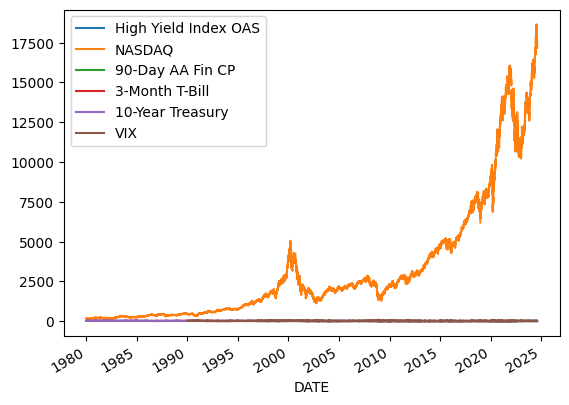

In [22]:
df.plot()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11726 entries, 1980-01-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   High Yield Index OAS  7202 non-null   float64
 1   NASDAQ                11241 non-null  float64
 2   90-Day AA Fin CP      6467 non-null   float64
 3   3-Month T-Bill        11148 non-null  float64
 4   10-Year Treasury      11148 non-null  float64
 5   VIX                   8727 non-null   float64
dtypes: float64(6)
memory usage: 641.3 KB


<Axes: xlabel='DATE'>

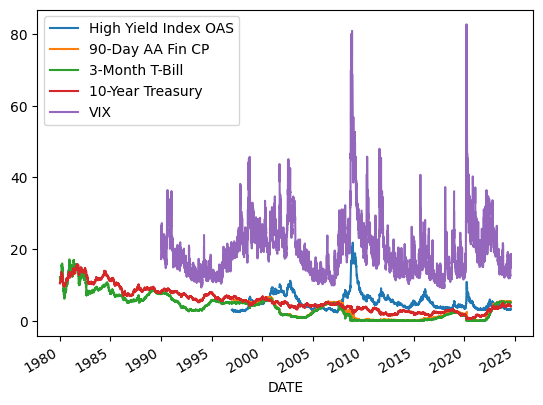

In [24]:
df.drop(columns=['NASDAQ']).plot()

Let's try some transformations like those used in the OFR Financial Stress Index: https://www.financialresearch.gov/financial-stress-index/files/indicators/index.html

In [25]:
dfn = pd.DataFrame().reindex_like(df)
dfn

,High Yield Index OAS,NASDAQ,90-Day AA Fin CP,3-Month T-Bill,10-Year Treasury,VIX
DATE,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-07-26,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-29,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-30,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df['NASDAQ'].rolling(250).mean()

DATE
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-07   NaN
              ..
2024-07-26   NaN
2024-07-29   NaN
2024-07-30   NaN
2024-07-31   NaN
2024-08-01   NaN
Name: NASDAQ, Length: 11726, dtype: float64

In [27]:
df = df.dropna()

In [28]:
df['NASDAQ'].rolling(250).mean()

DATE
1997-01-02            NaN
1997-01-03            NaN
1997-01-06            NaN
1997-01-07            NaN
1997-01-08            NaN
                 ...     
2024-07-12    13535.02176
2024-07-22    13564.74956
2024-07-25    13590.21472
2024-07-31    13615.90668
2024-08-01    13640.08872
Name: NASDAQ, Length: 6448, dtype: float64

In [29]:
# 'High Yield Index OAS': Leave as is
dfn['High Yield Index OAS'] = df['High Yield Index OAS']
dfn['CP - Treasury Spread, 3m'] = df['90-Day AA Fin CP'] - df['10-Year Treasury']
# 'NASDAQ':  # We're using something different, but still apply rolling mean transformation
dfn['NASDAQ'] = df['NASDAQ'] - df['NASDAQ'].rolling(250).mean()
dfn['10-Year Treasury'] = df['10-Year Treasury'] - df['10-Year Treasury'].rolling(250).mean()
# 'VIX': Leave as is
dfn['VIX'] = df['VIX']

In [30]:
dfn = dfn.drop(columns=['90-Day AA Fin CP', '3-Month T-Bill'])
dfn = dfn.dropna()

In [31]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6199 entries, 1998-01-05 to 2024-08-01
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   High Yield Index OAS      6199 non-null   float64
 1   NASDAQ                    6199 non-null   float64
 2   10-Year Treasury          6199 non-null   float64
 3   VIX                       6199 non-null   float64
 4   CP - Treasury Spread, 3m  6199 non-null   float64
dtypes: float64(5)
memory usage: 290.6 KB


We finished with our transformations. Now, let's normalize. First, why is it important?

<Axes: xlabel='DATE'>

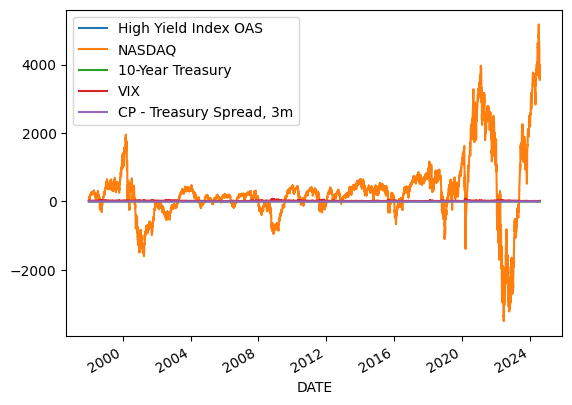

In [32]:
dfn.plot()

Now, normalize each column,
$$
z = \frac{x - \bar x}{\text{std}(x)}
$$

In [33]:
dfn = (dfn - dfn.mean()) / dfn.std()

<Axes: xlabel='DATE'>

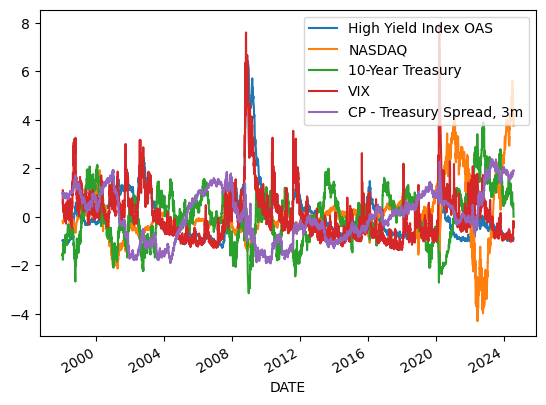

In [34]:
dfn.plot()

In [35]:
def pca(dfn, module='scikitlearn'):
    if module == 'statsmodels':
        _pc1, _loadings, projection, rsquare, _, _, _ = statsmodels.multivariate.pca.pca(dfn,
            ncomp=1, standardize=True, demean=True, normalize=True, gls=False,
            weights=None, method='svd')
        _loadings = _loadings['comp_0']
        loadings = np.std(_pc1) * _loadings
        pc1 = _pc1 / np.std(_pc1)
        pc1 = pc1.rename(columns={'comp_0':'PC1'})['PC1']

    elif module == 'scikitlearn':
        pca = sklearn.decomposition.PCA(n_components=1)
        _pc1 = pd.Series(pca.fit_transform(dfn)[:,0], index=dfn.index, name='PC1')
        _loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
        _loadings = pd.Series(_loadings[:,0], index=dfn.columns)

        loadings = np.std(_pc1) * _loadings
        pc1 = _pc1 / np.std(_pc1)
        pc1.name = 'PC1'
    else:
        raise ValueError



    loadings.name = "loadings"

    return pc1, loadings

def stacked_plot(df, filename=None):
    """
    df=category_contributions
    # category_contributions.sum(axis=1).plot()
    """

    df_pos = df[df >= 0]
    df_neg = df[df < 0]

    alpha = .3
    linewidth = .5

    ax = df_pos.plot.area(alpha=alpha, linewidth=linewidth, legend=False)
    pc1 = df.sum(axis=1)
    pc1.name = 'pc1'
    pc1.plot(color="Black", label='pc1', linewidth=1)


    plt.legend()
    ax.set_prop_cycle(None)
    df_neg.plot.area(alpha=alpha, ax=ax, linewidth=linewidth, legend=False, ylim=(-3,3))
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale()
    # ax.set_ylabel('Standard Deviations')
    # ax.set_ylim(-3,4)
    # ax.set_ylim(-30,30)

    if not (filename is None):
        filename = Path(filename)
        figure = plt.gcf() # get current figure
        figure.set_size_inches(8, 6)
        plt.savefig(filename, dpi=300)


In [36]:
pc1, loadings = pca(dfn, module='scikitlearn')

<Axes: xlabel='DATE'>

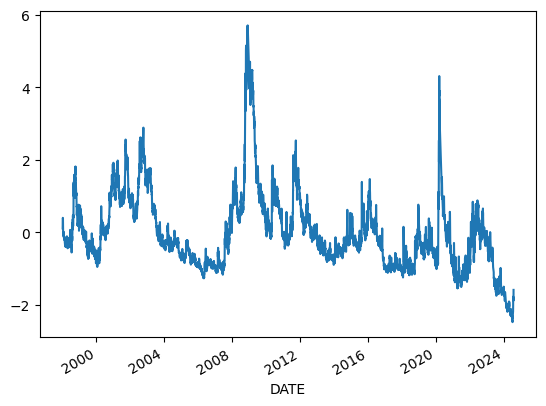

In [37]:
pc1.plot()

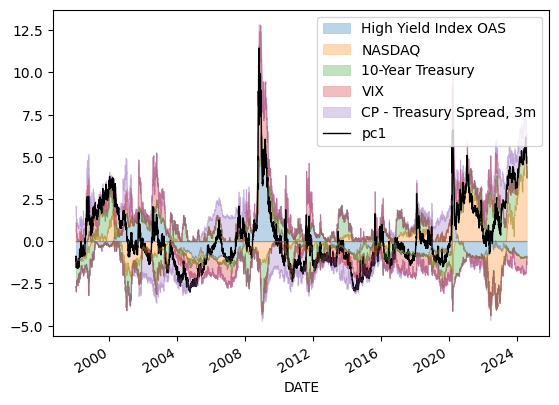

In [38]:
stacked_plot(dfn)

Let's compare solutions from two different packages

In [39]:
def root_mean_squared_error(sa, sb):
    return np.sqrt(np.mean((sa - sb)**2))

pc1_sk, loadings_sk = pca(dfn, module='scikitlearn')
pc1_sm, loadings_sm = pca(dfn, module='statsmodels')
root_mean_squared_error(pc1_sm, pc1_sk)

C:\Users\Jeremy\miniforge3\envs\finm\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


2.8699170475470133e-16

## Factor Analysis of a Panel of Stock Returns?

In [40]:
sample = yf.download("SPY AAPL MSFT", start="2017-01-01", end="2017-04-30")

[                       0%%                      ]

[*********************100%%**********************]  3 of 3 completed

In [41]:
sample

Price       Adj Close                             Close             \
Ticker           AAPL       MSFT         SPY       AAPL       MSFT   
Date                                                                 
2017-01-03  26.952711  56.930576  198.559998  29.037500  62.580002   
2017-01-04  26.922543  56.675854  199.741333  29.004999  62.299999   
2017-01-05  27.059448  56.675854  199.582626  29.152500  62.299999   
2017-01-06  27.361116  57.167095  200.296661  29.477501  62.840000   
2017-01-09  27.611732  56.985153  199.635529  29.747499  62.639999   
...               ...        ...         ...        ...        ...   
2017-04-24  33.476299  61.806141  209.986526  35.910000  67.529999   
2017-04-25  33.683716  62.163094  211.208344  36.132500  67.919998   
2017-04-26  33.485615  62.080730  211.075546  35.919998  67.830002   
2017-04-27  33.511250  62.483437  211.252594  35.947498  68.269997   
2017-04-28  33.478630  62.657322  210.792160  35.912498  68.459999   

Price                        High                               Low  \
Ticker             SPY       AAPL       MSFT         SPY       AAPL   
Date                                                                  
2017-01-03  225.240005  29.082500  62.840000  225.830002  28.690001   
2017-01-04  226.580002  29.127501  62.750000  226.750000  28.937500   
2017-01-05  226.399994  29.215000  62.660000  226.580002  28.952499   
2017-01-06  227.210007  29.540001  63.150002  227.750000  29.117500   
2017-01-09  226.460007  29.857500  63.080002  227.070007  29.485001   
...                ...        ...        ...         ...        ...   
2017-04-24  237.169998  35.987499  67.660004  237.410004  35.794998   
2017-04-25  238.550003  36.224998  68.040001  238.949997  35.967499   
2017-04-26  238.399994  36.150002  68.309998  239.529999  35.845001   
2017-04-27  238.600006  36.040001  68.379997  238.949997  35.827499   
2017-04-28  238.080002  36.075001  69.139999  238.929993  35.817501   

Price                                   Open                         \
Ticker           MSFT         SPY       AAPL       MSFT         SPY   
Date                                                                  
2017-01-03  62.130001  223.880005  28.950001  62.790001  225.039993   
2017-01-04  62.119999  225.610001  28.962500  62.480000  225.619995   
2017-01-05  62.029999  225.479996  28.980000  62.189999  226.270004   
2017-01-06  62.040001  225.899994  29.195000  62.299999  226.529999   
2017-01-09  62.540001  226.419998  29.487499  62.759998  226.910004   
...               ...         ...        ...        ...         ...   
2017-04-24  67.099998  234.559998  35.875000  67.480003  237.179993   
2017-04-25  67.599998  237.809998  35.977501  67.900002  237.910004   
2017-04-26  67.620003  238.350006  36.117500  68.080002  238.509995   
2017-04-27  67.580002  237.979996  35.980000  68.150002  238.770004   
2017-04-28  67.690002  237.929993  36.022499  68.910004  238.899994   

Price          Volume                       
Ticker           AAPL      MSFT        SPY  
Date                                        
2017-01-03  115127600  20694100   91366500  
2017-01-04   84472400  21340000   78744400  
2017-01-05   88774400  24876000   78379000  
2017-01-06  127007600  19922900   71559900  
2017-01-09  134247600  20382700   46939700  
...               ...       ...        ...  
2017-04-24   68537200  29770000  119209900  
2017-04-25   75486000  30242700   76698300  
2017-04-26   80164800  26190800   84702500  
2017-04-27   56985200  34971000   57410300  
2017-04-28   83441600  39548800   63532800  

[81 rows x 18 columns]

In [42]:
sample['Adj Close']

Ticker,AAPL,MSFT,SPY
Date,,,
2017-01-03,26.952711,56.930576,198.559998
2017-01-04,26.922543,56.675854,199.741333
2017-01-05,27.059448,56.675854,199.582626
2017-01-06,27.361116,57.167095,200.296661
2017-01-09,27.611732,56.985153,199.635529
...,...,...,...
2017-04-24,33.476299,61.806141,209.986526
2017-04-25,33.683716,62.163094,211.208344
2017-04-26,33.485615,62.080730,211.075546


In [43]:
tickers = [
    'AAPL','ABBV','ABT','ACN','ADP','ADSK','AES','AET','AFL','AMAT','AMGN','AMZN','APA',
    'APHA','APD','APTV','ARE','ASML','ATVI','AXP','BA','BAC','BAX','BDX','BIIB','BK',
    'BKNG','BMY','BRKB','BRK.A','COG','COST','CPB','CRM','CSCO','CVS','DAL','DD','DHR',
    'DIS','DOW','DUK','EMR','EPD','EQT','ESRT','EXPD','FFIV','FLS','FLT','FRT','GE',
    'GILD','GOOGL','GOOG','GS','HAL','HD','HON','IBM','INTC','IP','JNJ','JPM','KEY',
    'KHC','KIM','KO','LLY','LMT','LOW','MCD','MCHP','MDT','MMM','MO','MRK','MSFT',
    'MTD','NEE','NFLX','NKE','NOV','ORCL','OXY','PEP','PFE','PG','RTN','RTX','SBUX',
    'SHW','SLB','SO','SPG','STT','T','TGT','TXN','UNH','UPS','USB','UTX','V','VZ',
    'WMT','XOM',
]

In [44]:
" ".join(tickers)

'AAPL ABBV ABT ACN ADP ADSK AES AET AFL AMAT AMGN AMZN APA APHA APD APTV ARE ASML ATVI AXP BA BAC BAX BDX BIIB BK BKNG BMY BRKB BRK.A COG COST CPB CRM CSCO CVS DAL DD DHR DIS DOW DUK EMR EPD EQT ESRT EXPD FFIV FLS FLT FRT GE GILD GOOGL GOOG GS HAL HD HON IBM INTC IP JNJ JPM KEY KHC KIM KO LLY LMT LOW MCD MCHP MDT MMM MO MRK MSFT MTD NEE NFLX NKE NOV ORCL OXY PEP PFE PG RTN RTX SBUX SHW SLB SO SPG STT T TGT TXN UNH UPS USB UTX V VZ WMT XOM'

In [45]:
data = yf.download(" ".join(tickers), start="1980-01-01", end="2023-08-01")

[                       0%%                      ]

[*                      2%%                      ]  2 of 107 completed

[*                      3%%                      ]  3 of 107 completed

[**                     4%%                      ]  4 of 107 completed

[**                     5%%                      ]  5 of 107 completed

[***                    6%%                      ]  6 of 107 completed

[***                    7%%                      ]  7 of 107 completed

[***                    7%%                      ]  8 of 107 completed

[****                   8%%                      ]  9 of 107 completed

[****                   9%%                      ]  10 of 107 completed

[*****                 10%%                      ]  11 of 107 completed

[******                12%%                      ]  13 of 107 completed

[******                13%%                      ]  14 of 107 completed

[*******               14%%                      ]  15 of 107 completed

[*******               15%%                      ]  16 of 107 completed

[********              17%%                      ]  18 of 107 completed

[*********             18%%                      ]  19 of 107 completed

[*********             19%%                      ]  20 of 107 completed

[**********            20%%                      ]  21 of 107 completed

[**********            21%%                      ]  22 of 107 completed

[**********            21%%                      ]  23 of 107 completed

[***********           22%%                      ]  24 of 107 completed

[***********           23%%                      ]  25 of 107 completed

[************          24%%                      ]  26 of 107 completed

[************          25%%                      ]  27 of 107 completed

[************          25%%                      ]  27 of 107 completed

[*************         28%%                      ]  30 of 107 completed

[**************        29%%                      ]  31 of 107 completed

[**************        30%%                      ]  32 of 107 completed

[***************       31%%                      ]  33 of 107 completed

[****************      33%%                      ]  35 of 107 completed

[****************      34%%                      ]  36 of 107 completed

[*****************     35%%                      ]  37 of 107 completed

[*****************     36%%                      ]  38 of 107 completed

[*****************     36%%                      ]  39 of 107 completed

[******************    37%%                      ]  40 of 107 completed

[******************    38%%                      ]  41 of 107 completed

[*******************   39%%                      ]  42 of 107 completed

[*******************   40%%                      ]  43 of 107 completed

[********************  41%%                      ]  44 of 107 completed

[********************  42%%                      ]  45 of 107 completed

[********************* 43%%                      ]  46 of 107 completed

[********************* 44%%                      ]  47 of 107 completed

[**********************45%%                      ]  48 of 107 completed

[**********************46%%                      ]  49 of 107 completed

[**********************47%%                      ]  50 of 107 completed

[**********************48%%                      ]  51 of 107 completed

[**********************49%%                      ]  52 of 107 completed

[**********************50%%                      ]  53 of 107 completed

[**********************50%%                      ]  54 of 107 completed

[**********************51%%                      ]  55 of 107 completed

[**********************52%%                      ]  56 of 107 completed

[**********************53%%                      ]  57 of 107 completed

[**********************54%%                      ]  58 of 107 completed

[**********************55%%                      ]  59 of 107 completed

[**********************56%%*                     ]  60 of 107 completed

[**********************57%%*                     ]  61 of 107 completed

[**********************58%%**                    ]  62 of 107 completed

[**********************59%%**                    ]  63 of 107 completed

[**********************60%%***                   ]  64 of 107 completed

[**********************61%%***                   ]  65 of 107 completed

[**********************62%%****                  ]  66 of 107 completed

[**********************63%%****                  ]  67 of 107 completed

[**********************64%%*****                 ]  68 of 107 completed

[**********************64%%*****                 ]  69 of 107 completed

[**********************65%%*****                 ]  70 of 107 completed

[**********************66%%******                ]  71 of 107 completed

[**********************67%%******                ]  72 of 107 completed

[**********************68%%*******               ]  73 of 107 completed

[**********************69%%*******               ]  74 of 107 completed

[**********************70%%********              ]  75 of 107 completed

[**********************71%%********              ]  76 of 107 completed

[**********************72%%*********             ]  77 of 107 completed

[**********************73%%*********             ]  78 of 107 completed

[**********************75%%**********            ]  80 of 107 completed

[**********************76%%**********            ]  81 of 107 completed

[**********************76%%**********            ]  81 of 107 completed

[**********************78%%***********           ]  83 of 107 completed

[**********************79%%************          ]  84 of 107 completed

[**********************79%%************          ]  85 of 107 completed

[**********************80%%************          ]  86 of 107 completed

[**********************81%%*************         ]  87 of 107 completed

[**********************82%%*************         ]  88 of 107 completed

[**********************83%%**************        ]  89 of 107 completed

[**********************84%%**************        ]  90 of 107 completed

[**********************85%%***************       ]  91 of 107 completed

[**********************86%%***************       ]  92 of 107 completed

[**********************87%%****************      ]  93 of 107 completed

[**********************87%%****************      ]  93 of 107 completed

[**********************89%%*****************     ]  95 of 107 completed

[**********************90%%*****************     ]  96 of 107 completed

[**********************91%%******************    ]  97 of 107 completed

[**********************92%%******************    ]  98 of 107 completed

[**********************93%%*******************   ]  99 of 107 completed

[**********************93%%*******************   ]  100 of 107 completed

[**********************94%%*******************   ]  101 of 107 completed

[**********************95%%********************  ]  102 of 107 completed

[**********************96%%********************  ]  103 of 107 completed

[**********************98%%********************* ]  105 of 107 completed

[**********************99%%**********************]  106 of 107 completed

[*********************100%%**********************]  107 of 107 completed



8 Failed downloads:


['ATVI', 'APHA', 'BRKB', 'FLT', 'RTN', 'UTX', 'BRK.A', 'COG']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


<Axes: xlabel='Date'>

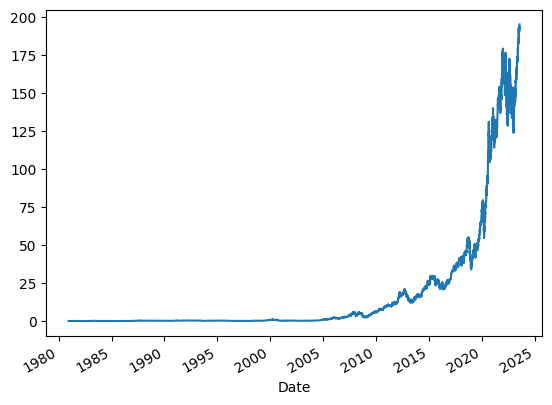

In [46]:
data['Adj Close']['AAPL'].plot()

In [47]:
cols_with_many_nas = [
    "BRK.A",
    "APHA",
    "UTX",
    "RTN",
    "COG",
    "BRKB",
    "ATVI",
    "FLT",
    "DOW",
    "KHC",
    "V",
    "APTV",
    "ABBV",
    "ESRT",
]
df = data['Adj Close']
df = df.drop(columns=cols_with_many_nas).dropna().pct_change().dropna()


<Axes: xlabel='Date'>

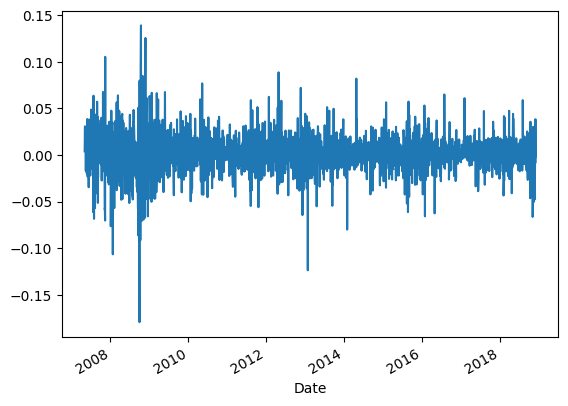

In [48]:
df['AAPL'].plot()

In [49]:
pc1, loadings = pca(df, module='scikitlearn')

<Axes: xlabel='Date'>

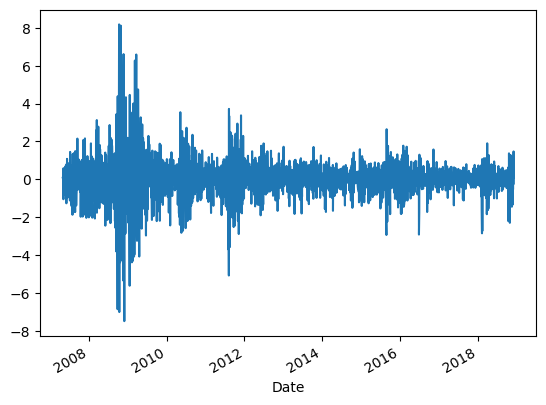

In [50]:
pc1.plot()

<Axes: xlabel='Date'>

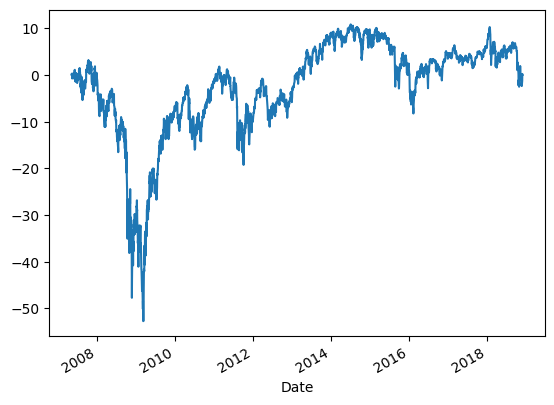

In [51]:
pc1.cumsum().plot()

 - Why does this plot only go back to 2019? What happened? 
 - What are methods that we might use to deal with missing data?